Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 2.5105, Acc: 0.2170
Epoch 2/20, Loss: 2.1447, Acc: 0.3266
Epoch 3/20, Loss: 1.9438, Acc: 0.3879
Epoch 4/20, Loss: 1.8070, Acc: 0.4309
Epoch 5/20, Loss: 1.6834, Acc: 0.4681
Epoch 6/20, Loss: 1.5774, Acc: 0.5033
Epoch 7/20, Loss: 1.4788, Acc: 0.5319
Epoch 8/20, Loss: 1.3867, Acc: 0.5609
Epoch 9/20, Loss: 1.2987, Acc: 0.5877
Epoch 10/20, Loss: 1.2136, Acc: 0.6119
Epoch 11/20, Loss: 1.1427, Acc: 0.6364
Epoch 12/20, Loss: 1.0691, Acc: 0.6592
Epoch 13/20, Loss: 1.0057, Acc: 0.6793
Epoch 14/20, Loss: 0.9450, Acc: 0.6982
Epoch 15/20, Loss: 0.8866, Acc: 0.7137
Epoch 16/20, Loss: 0.8276, Acc: 0.7334
Epoch 17/20, Loss: 0.7776, Acc: 0.7490
Epoch 18/20, Loss: 0.7346, Acc: 0.7652
Epoch 19/20, Loss: 0.6921, Acc: 0.7776
Epoch 20/20, Loss: 0.6494, Acc: 0.7913
Test Loss: 1.1840, Test Acc: 0.6605


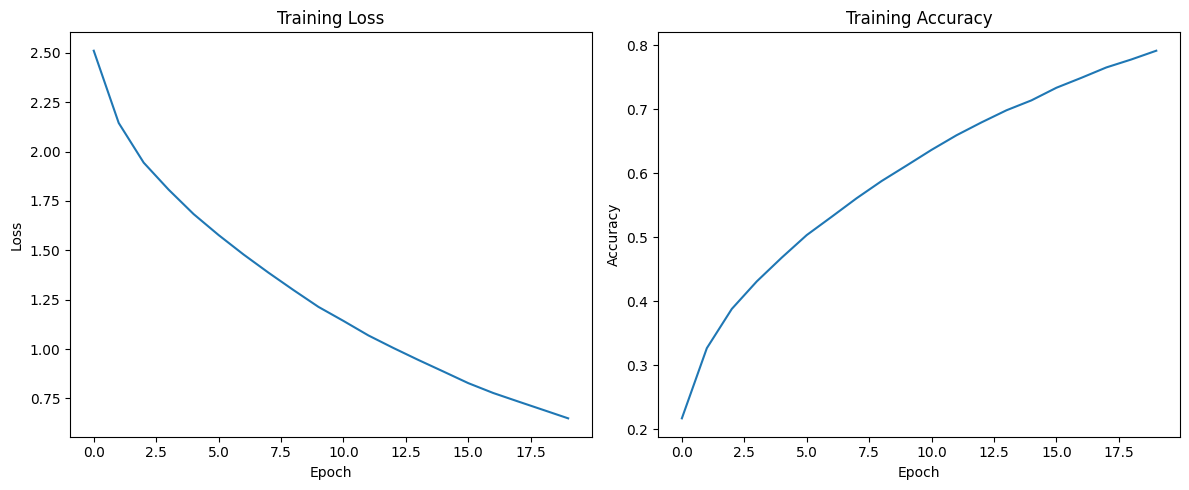

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Función para obtener coarse labels
def get_coarse_label(fine_label):
    coarse_labels = [
        4, 1, 14, 8, 0, 6, 7, 7, 18, 3,
        3, 14, 9, 18, 7, 11, 3, 9, 7, 11,
        6, 11, 5, 10, 7, 6, 13, 15, 3, 15,
        0, 11, 1, 10, 12, 14, 16, 9, 11, 5,
        5, 19, 8, 8, 15, 13, 14, 17, 18, 10,
        16, 4, 17, 4, 2, 0, 17, 4, 18, 17,
        10, 3, 2, 12, 12, 16, 12, 1, 9, 19,
        2, 10, 0, 1, 16, 12, 9, 13, 15, 13,
        16, 19, 2, 4, 6, 19, 5, 5, 8, 19,
        18, 1, 2, 15, 6, 0, 17, 8, 14, 13
    ]
    return coarse_labels[fine_label]

# Cargar y preparar el conjunto de datos CIFAR-100
transform = ToTensor()
train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform)

# Convertir a coarse labels
train_dataset.targets = [get_coarse_label(label) for label in train_dataset.targets]
test_dataset.targets = [get_coarse_label(label) for label in test_dataset.targets]

# Crear data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definir el modelo
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 20)  # 20 clases para las etiquetas gruesas
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # print(x.shape)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # print(x.shape)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # print(x.shape)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        # print(x.shape)
        x = self.dropout(x)
        
        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Inicializar el modelo, criterio y optimizador
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Bucle de entrenamiento
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

# Evaluación en el conjunto de prueba
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss = test_loss / len(test_loader)
test_acc = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Graficar la pérdida y precisión de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()